## The global warming issue and Narratives around it<br>
### Part 4: Performing modeling on the pickled reddit dataset

In this notebook, I set the stage for tnuning and scoring the following models:

- **Logistic Regression** ---> only on vectorized text (bag of words: CountVectorizer<br><br>
- **Naïve Bayes** ---> only on vectorized text, vectorized by CountVectorizer<br>
- **Naïve Bayes** ---> only on vectorized text, vectorized by TF-IDF vectorizer<br><br>
- **Random forest** ---> only on vectorized text, vectorized by CountVectorizer<br>
- **Extra tress** ---> only on vectorized text, vectorized by CountVectorizer<br>
- **GBoost** ---> only on vectorized text (using CountVectorizer)<br>
- **Neural Network** ---> only on vectorized text (using CountVectorizer)<br>
- **support vector machine (SVM)** ---> only on vectorized text (using CountVectorizer)<br>



`- Note: In this notebook, we only studied the model performance on text douments to compare the models`



Importing the require libraries:

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import eli5

import regex as re
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

from nltk.corpus import stopwords

import pickle

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Part 4.1: Importing the saved dataframe

In [2]:
df_reddit = pickle.load(open('../datasets/df_reddit_for_model.pkl', 'rb'))
df_reddit.head()

,author,created_utc,id,num_comments,over_18,post_hint,score,subreddit_subscribers,text_merged,subreddit,text_char_count,text_word_count,sentiment_score,date,target
0,Kafka15,1593554514,hixbtf,2,0,image,1,6157.0,cum,GlobalWarming,3,1,0.0000,2020-06-30 22:01:54,1
1,karan_negiiiii,1593497051,hihj6s,0,0,Empty,1,6156.0,climat chang india,GlobalWarming,18,3,0.0000,2020-06-30 06:04:11,1
2,Hildavardr,1593479932,hidb5h,0,0,Empty,1,6154.0,global warm respons big compani,GlobalWarming,31,5,0.2263,2020-06-30 01:18:52,1
3,pEppapiGistfuhrer,1593455137,hi5h41,1,0,image,1,6152.0,ayi let stop global warm,GlobalWarming,24,5,-0.0772,2020-06-29 18:25:37,1
4,BrexitBlaze,1593455005,hi5feq,2,0,link,2,6152.0,uk minist send mix messag climat commit say fu...,GlobalWarming,66,13,0.2960,2020-06-29 18:23:25,1


In [3]:
df_reddit.shape

(4828, 15)

---

## Bootstrapped the under-represented class to balance the classes:

In [4]:
n_bts_sample = df_reddit[(df_reddit["subreddit"]=="GlobalWarming")].shape[0] - df_reddit[(df_reddit["subreddit"]=="ConspiracyTheory")].shape[0]

df_btsp = df_reddit[(df_reddit["subreddit"]=="ConspiracyTheory")].sample(n = n_bts_sample, replace=True, random_state=42)

df_reddit_btsp = pd.concat([df_reddit, df_btsp])

df_reddit_btsp.reset_index(drop=True, inplace=True)

---

## Defining X and Y variables:

In [5]:
X = df_reddit_btsp['text_merged']
y = df_reddit_btsp['target']

---

## **Train/test split:**

### Defining variables

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify=y,
                                                    random_state = 42)

Checking for stratified target variables:

In [7]:
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: target, dtype: float64

In [8]:
y_train.value_counts(normalize=True)

1    0.500085
0    0.499915
Name: target, dtype: float64

In [9]:
y_test.value_counts(normalize=True)

0    0.500254
1    0.499746
Name: target, dtype: float64

## Baseline accuracy:

In [10]:
y_test.value_counts(normalize=True)

0    0.500254
1    0.499746
Name: target, dtype: float64

Hence, 50%, this is the worst we are allowed to do!

## Looking for more stop words by vectoring

In [11]:
#Adding a stop word list which I derived from an initial plot:
#list_stop_words = ["dec", "http", "www", "chang", "com"]

vectorizer = CountVectorizer(analyzer = "word",
                             #ngram_range=(1,2),
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 3000) 


X_train_features = vectorizer.fit_transform(X_train)

#X_test_features = vectorizer.transform(X_test)

In [12]:
X_train_features_df = pd.DataFrame(X_train_features.toarray(),
                          columns=vectorizer.get_feature_names())
X_train_features_df.head(2)

,abandon,abduct,abducte,abil,abl,absolut,absorb,abus,ac,accept,...,younger,youth,youtu,youtub,zag,zealand,zero,zeu,zombi,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Looking into which words are used alot:

In [13]:
# get count of top-occurring words

# empty dictionary
top_words = {}

# loop through columns
for i in X_train_features_df.columns:
    # save sum of each column in dictionary
    top_words[i] =  X_train_features_df[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))
most_freq.head(10)

,0,1
0,global,1318
1,warm,1231
2,world,1117
3,http,1018
4,climat,962
5,like,953
6,peopl,891
7,chang,888
8,would,804
9,us,783


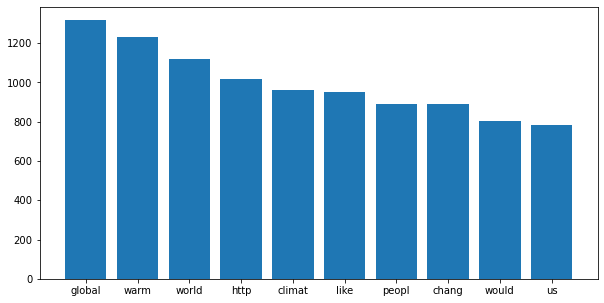

In [14]:
plt.figure(figsize = (10, 5))

# visualize top 10 words
plt.bar(most_freq[0][:10], most_freq[1][:10]);

# To remove words !

In [15]:
list_stop_words = ["dec", "global", "http", "www", "com", "conspiraci", "warm", "climat", "remov", "theori", "theactualshadow", "co"]

## Part 4.2- **Logistic Regression**
## only on vectorized text (bag of words: CountVectorizer)

Designing the pipe:

In [16]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [17]:
pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__stop_words': [list_stop_words, 'english'],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [18]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [19]:
gs.fit(X_train, y_train);

In [20]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [21]:
# Score model on training set.
gs.score(X_train, y_train)

0.9913573970513472

In [22]:
# Score model on testing set.
gs.score(X_test, y_test)

0.9639044229791561

In [23]:
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

#plot_confusion_matrix(gs, X_test_features, y_test, cmap='Blues', values_format='d');

## Now, running a base log-reg to look at the words that were important: 

In [24]:
vectorizer = CountVectorizer(analyzer = "word",
                             #ngram_range=(1,2),
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = list_stop_words,
                             max_features = 3000) 


X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

In [25]:
lr = LogisticRegression(solver='newton-cg')

In [26]:
lr.fit(X_train_features, y_train);

In [27]:
lr.score(X_train_features, y_train)

0.9774614472123369

In [28]:
lr.score(X_test_features, y_test)

0.9323843416370107

Creating a dataframe to look at the coefficient of the basae model:

In [29]:
df_coeffs = pd.DataFrame()
df_coef= pd.DataFrame(lr.coef_).T
df_feat = pd.DataFrame(vectorizer.get_feature_names())

df_lr_coefs=pd.concat([df_feat, df_coef], axis=1)
df_lr_coefs.columns = ["feature_names", "LR_coefficients"]
df_lr_coefs_sorted = df_lr_coefs.sort_values(by =["LR_coefficients"], ascending=False, ignore_index=True)
df_lr_coefs_sorted

,feature_names,LR_coefficients
0,chang,2.701103
1,carbon,2.277294
2,scientist,2.004883
3,emiss,1.964167
4,environment,1.907267
...,...,...
2995,moon,-2.058871
2996,illuminati,-2.123301
2997,assassin,-2.135199
2998,mandela,-2.440148


In [30]:
df_lr_coefs_sorted.head(10)

,feature_names,LR_coefficients
0,chang,2.701103
1,carbon,2.277294
2,scientist,2.004883
3,emiss,1.964167
4,environment,1.907267
5,temperatur,1.851639
6,futur,1.590890
7,ice,1.564098
8,hottest,1.491541
9,environ,1.482627


In [31]:
df_lr_coefs_sorted.tail(10)

,feature_names,LR_coefficients
2990,epstein,-1.839416
2991,control,-1.848390
2992,dead,-1.859572
2993,iran,-2.003617
2994,ufo,-2.045038
2995,moon,-2.058871
2996,illuminati,-2.123301
2997,assassin,-2.135199
2998,mandela,-2.440148
2999,alien,-2.650792


In [32]:
df_lr_coefs_sorted.shape

(3000, 2)

## Part 4.3- **Naïve Bayes** <br><br>(only on vectorized text, vectorized by CountVectorizer)

#### Designing a pipeline for Bayes analysis to fine-tune the model and get best scores

In [33]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [34]:
cross_val_score(pipe, X_train, y_train, cv=3).mean()

0.9405185561769192

In [35]:
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

0.9666158278257923

In [36]:
pipe.score(X_test, y_test)

0.9466192170818505

Since we want to tune over the CountVectorizer, we'll load our pipeline object into GridSearchCV:

In [37]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [38]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [39]:
gs.fit(X_train, y_train);

In [40]:
# What's the best score?
print(gs.best_score_)

0.9303520429397667


In [41]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [42]:
# Score model on training set.
gs.score(X_train, y_train)

0.9535671920013558

In [43]:
# Score model on testing set.
gs.score(X_test, y_test)

0.9374682257244534

In [44]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

#plot_confusion_matrix(gs, X_test_features, y_test, cmap='Blues', values_format='d');

## Part 4.4- **Naïve Bayes** <br><br>(only on vectorized text, vectorized by TF-IDF vectorizer)

In [45]:
# Instantiate the transformer.
tvec = TfidfVectorizer()

In [46]:
df = pd.DataFrame(tvec.fit_transform(X_train).toarray(),
                  columns=tvec.get_feature_names())
df.head()

,aa,aacgtmjui,aaliyah,aaron,aass,ab,aback,abandon,abbott,abbrevi,...,zoo,zoom,zorgt,zq,zr,ztiu,zuck,zuckerberg,zvhm,zwhvc
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Designing a pipeline for TF-IDF analysis

In [47]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [48]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [49]:
# Instantiate GridSearchCV.

gs_tvec = GridSearchCV(pipe_tvec, # what object are we optimizing?
                        param_grid = pipe_tvec_params, # what parameters values are we searching?
                        cv=5) # 5-fold cross-validation.

In [50]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train);

In [51]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.9674631418403661

In [52]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.9476359938993391

In [53]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.9634146341463414


<Figure size 1440x1152 with 0 Axes>

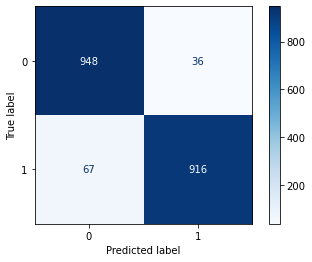

In [54]:
# visualize this
plt.figure(figsize=(20,16))

plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d');
plt.savefig("../plots/Confusion.png")

## Part 4.5- **Random forest** <br> <br> (only on vectorized text, vectorized by CountVectorizer)

Create an instance of RandomForestClassifier.

In [55]:
rf = RandomForestClassifier()


rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train_features, y_train)
print(gs.best_score_)
gs.best_params_



0.9427223410209675


{'max_depth': None, 'n_estimators': 200}

In [56]:
gs.score(X_train_features, y_train)

0.9923741738688358

In [57]:
gs.score(X_test_features, y_test)

0.9598373157092018

## Part 4.6- **Extra tress** <br> <br> (only on vectorized text, vectorized by CountVectorizer)

In [58]:
et = ExtraTreesClassifier(n_estimators=100)


rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}
gs = GridSearchCV(et, param_grid=rf_params, cv=5)
gs.fit(X_train_features, y_train)
print(gs.best_score_)
gs.best_params_

0.943739146658247


{'max_depth': None, 'n_estimators': 200}

In [59]:
gs.score(X_train_features, y_train)

0.9923741738688358

In [60]:
gs.score(X_test_features, y_test)

0.9649211997966446

## Part 4.7- **GBoost** <br> <br> only on vectorized text (using CountVectorizer)

In [61]:
gboost = GradientBoostingClassifier()
gboost_params = {
    'max_depth': [2,3,4],
    'n_estimators': [100, 125, 150],
    'learning_rate': [.08, .1, .12]
}
gb_gs = GridSearchCV(gboost, param_grid=gboost_params, cv=3)
gb_gs.fit(X_train_features, y_train)
print(gb_gs.best_score_)
gb_gs.best_params_

0.859345873580749


{'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 150}

In [62]:
gb_gs.score(X_train_features, y_train)

0.9020504999152686

In [63]:
gb_gs.score(X_test_features, y_test)

0.8530757498729029

## Part 4.8- **Neural Network** <br> <br> only on vectorized text (using CountVectorizer)

In [64]:
from sklearn.neural_network import MLPClassifier

In [65]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [66]:
mlp.fit(X_train_features,y_train)

MLPClassifier(hidden_layer_sizes=(30, 30, 30))

In [67]:
mlp.score(X_train_features, y_train)

0.9923741738688358

In [68]:
mlp.score(X_test_features, y_test)

0.9400101677681749

## Part 4.9- **support vector machine (SVM)** <br> <br> only on vectorized text (using CountVectorizer)

In [69]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [70]:
svc = SVC(
    C = 100,
    kernel = "rbf",
    gamma = "scale"
)

# Fit on training data.
svc.fit(X_train_features, y_train)

SVC(C=100)

In [71]:
# Evaluate model.
accuracy_score(y_test, svc.predict(X_test_features))

0.9379766141331978